In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="white")
import networkx as nx

In [3]:
mean = (1, 2)
cov = [[1, 0], [0, 1]]
X = np.random.multivariate_normal(mean, cov, 1000)

In [4]:
from GrowingNetwork import GrowingNetwork

In [6]:
import warnings
warnings.filterwarnings('ignore')
gw = GrowingNetwork(X, a=0.6, h=0.5)
gw.fit(X)

<GrowingNetwork.GrowingNetwork instance at 0x7f774c0f3a70>

In [7]:
y_pred = gw.predict(X)

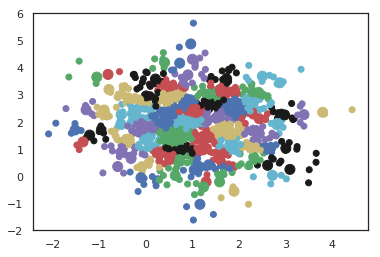

In [8]:
# plt.plot(X[:,0], X[:,1], '.b')
# plt.plot(gw.A[:,0], gw.A[:,1], '.r')
# plt.plot(X[1,0], X[1,1], '.k')
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * gw.A.shape[0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:,0], X[:,1],color=colors[y_pred].tolist())
center_colors = colors[:gw.A.shape[0]]
plt.scatter(gw.A[:, 0], gw.A[:, 1], s=100, c=center_colors)

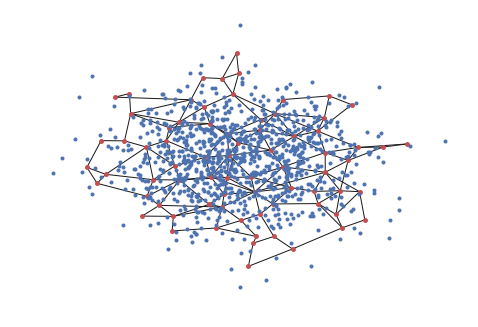

In [9]:
G=nx.Graph()
G.add_nodes_from(range(gw.A.shape[0]))
pos = dict(zip(range(gw.A.shape[0]), gw.A))
rows, cols = np.where(gw.connections == 1)
edges = zip(rows.tolist(), cols.tolist())
G.add_edges_from(edges)
nx.draw(G, pos, node_size=15)
plt.plot(X[:,0], X[:,1], '.b')
plt.show()

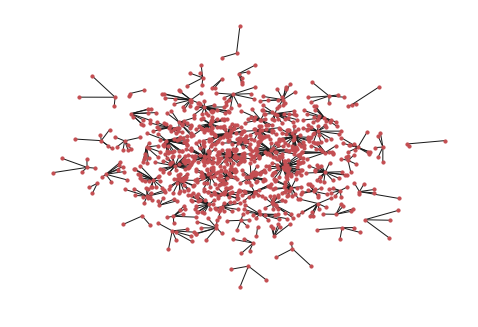

In [10]:
B=nx.Graph()
sample_range = range(gw.A.shape[0], gw.A.shape[0]+X.shape[0])
# Add samples as nodes
B.add_nodes_from(sample_range, size=5)
pos = dict(zip(range(gw.A.shape[0]+X.shape[0]), np.row_stack((gw.A,X))))
edges = zip(sample_range, y_pred)
B.add_edges_from(edges)
nx.draw(B, pos, node_size=10)

<b>Check for Convergence</b><br>
To check for convergence see if the neuron converges to the median or mean for each cluster

In [11]:
avg_dist_mean = 0
avg_dist_median = 0
for i in range(gw.A.shape[0]):
    mean = np.mean(X[np.where(y_pred==i)], axis=0)
    median = np.median(X[np.where(y_pred==i)], axis=0)
    d_mean = np.linalg.norm(gw.A[i,:]-mean, ord=1)
    d_median = np.linalg.norm(gw.A[i,:]-median, ord=1)
    print("Node {0} : Distance from Mean {1}\t Distance from Median {2}".format(i, d_mean, d_median))
    avg_dist_mean+=d_mean
    avg_dist_median+=d_median
print("Average distance from mean {0}".format(avg_dist_mean/gw.A.shape[0]))
print("Average distance from median {0}".format(avg_dist_median/gw.A.shape[0]))

Node 0 : Distance from Mean 0.054620109335	 Distance from Median 0.0524234089101
Node 1 : Distance from Mean 0.0679142698391	 Distance from Median 0.109258282435
Node 2 : Distance from Mean 0.0763590471149	 Distance from Median 0.121549584277
Node 3 : Distance from Mean 0.0824501254062	 Distance from Median 0.121284027341
Node 4 : Distance from Mean 0.0679446258617	 Distance from Median 0.0918988579862
Node 5 : Distance from Mean 0.05716646871	 Distance from Median 0.124099022833
Node 6 : Distance from Mean 0.129859631131	 Distance from Median 0.0940451264175
Node 7 : Distance from Mean 0.111151361165	 Distance from Median 0.116389841166
Node 8 : Distance from Mean 0.0976315469777	 Distance from Median 0.144016895403
Node 9 : Distance from Mean 0.0251258497968	 Distance from Median 0.0358287718756
Node 10 : Distance from Mean 0.121396908307	 Distance from Median 0.0782605407832
Node 11 : Distance from Mean 0.0304859160266	 Distance from Median 0.106081128442
Node 12 : Distance from Mea

Automatically created module for IPython interactive environment


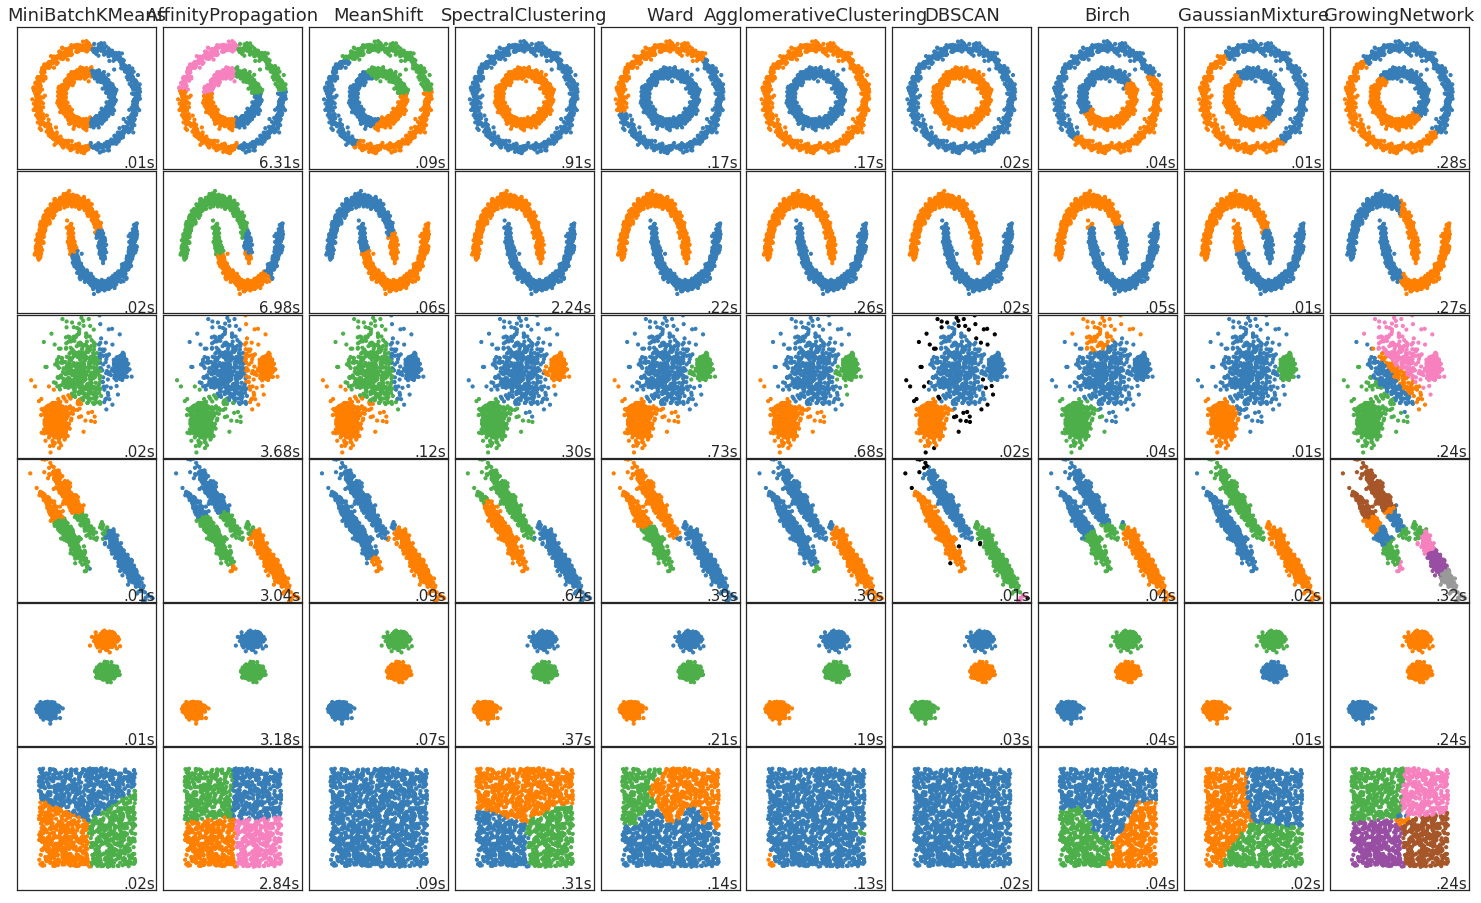

In [12]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ("GrowingNetwork", GrowingNetwork)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            if name=="GrowingNetwork":
                algorithm = GrowingNetwork(X)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()
